
## International Migration Flows to and from Selected Countries

### The 2015 Revision

### Exploratory Data Analysis using Python

In [3]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql.functions import pandas_udf
import pandas as pd
import numpy as np
import getpass
import hashlib
from datetime import datetime
import time
import os

### Installig Pyspark SQL

In [1]:
#pip install pyspark[sql]

### Spark Context

In [4]:
conf = SparkConf().setAppName("DanApp").setMaster("spark://172.25.0.101:7077")
sc = SparkContext(conf=conf)

### Spark Session

In [5]:
#sc = SparkContext.builder.appName("DanApp").getOrCreate()

### Enable Arrow-based columnar data transfers

In [19]:
#spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [6]:
FILE_NAME = 'Canada.xlsx'

In [7]:
#  md5sum Canada.xlsx

with open(FILE_NAME, "rb") as f:
    file_hash_md5 = hashlib.md5()
    while chunk := f.read(8192):
        file_hash_md5.update(chunk)
print(file_hash_md5.hexdigest())

ba18e956238fbd164e3c063d7bf100af


In [8]:
# sha256sum Canada.xlsx

with open(FILE_NAME, "rb") as f:
    file_hash_256 = hashlib.sha256()
    while chunk := f.read(8192):
        file_hash_256.update(chunk)
print(file_hash_256.hexdigest())

dd2022b503cb434b6a2e72e6576d01d10a45f60cf2ff1fcdd5b34cebef590576


In [9]:
df_canada = pd.read_excel(FILE_NAME, sheet_name='Regions by Citizenship', skiprows=20)
df_canada_citizen = pd.read_excel(FILE_NAME, sheet_name='Canada by Citizenship', skiprows=1)

In [10]:
LOAD_DATE = time.strftime('%Y %b %d (%a) %H:%M:%S', time.gmtime())
FILE_NAME
USER_NAME = getpass.getuser();
PATH = os.getcwd();
FILE_DATE = time.strftime('%Y %b %d (%a) %H:%M:%S', time.gmtime(os.path.getmtime(FILE_NAME)))
SIZE = os.path.getsize(FILE_NAME)
HASH_MD5 = file_hash_md5.hexdigest()
HASH_SHA256 = file_hash_256.hexdigest()

In [11]:
df_file_audit_trail = pd.DataFrame({'LOAD_DATE': LOAD_DATE,
                                   'FILE_NAME': FILE_NAME,
                                   'USER_NAME': USER_NAME,
                                   'PATH': PATH,
                                   'FILE_DATE': FILE_DATE,
                                   'SIZE': SIZE,
                                   'HASH_MD5': HASH_MD5,
                                   'HASH_SHA256': HASH_SHA256}, index=[0])
df_file_audit_trail


,LOAD_DATE,FILE_NAME,USER_NAME,PATH,FILE_DATE,SIZE,HASH_MD5,HASH_SHA256
0,2021 Jan 04 (Mon) 16:40:23,Canada.xlsx,jovyan,/home/jovyan/spark,2020 Nov 12 (Thu) 14:48:26,217195,ba18e956238fbd164e3c063d7bf100af,dd2022b503cb434b6a2e72e6576d01d10a45f60cf2ff1f...


## Unpivot

In [12]:
df_canada_mlt = pd.melt(df_canada, id_vars=['Type','Coverage','AreaName','RegName'])
df_canada_mlt.head(2)

,Type,Coverage,AreaName,RegName,variable,value
0,Immigrants,Citizens,Northern America,Northern America,1980,..
1,Immigrants,Foreigners,Africa,Eastern Africa,1980,1471


In [13]:
df_canada_citizen.head(2)

,Type,Coverage,OdName,AREA,AreaName,REG,RegName,DEV,DevName,1980,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,Immigrants,Foreigners,Afghanistan,935,Asia,5501,Southern Asia,902,Developing regions,16,...,2978,3436,3009,2652,2111,1746,1758,2203,2635,2004
1,Immigrants,Foreigners,Albania,908,Europe,925,Southern Europe,901,Developed regions,1,...,1450,1223,856,702,560,716,561,539,620,603


In [14]:
df_canada_citizen_mlt = pd.melt(df_canada_citizen, \
                                id_vars=['Type','Coverage','OdName','AREA','AreaName','REG','RegName','DEV','DevName'])
df_canada_citizen_mlt.head(2)

,Type,Coverage,OdName,AREA,AreaName,REG,RegName,DEV,DevName,variable,value
0,Immigrants,Foreigners,Afghanistan,935,Asia,5501,Southern Asia,902,Developing regions,1980,16
1,Immigrants,Foreigners,Albania,908,Europe,925,Southern Europe,901,Developed regions,1980,1


## Cleaning

* Regions by Citizenship
* Canada by Citizenship

** Canada by Citizenship

In [122]:
df_canada_citizen_mlt.columns = ['Type','Coverage','OdName','AREA','AreaName','REG','RegName','DEV','DevName','DateYear','PeopleQtd']
df_canada_citizen_mlt['PeopleQtd'] = pd.to_numeric(df_canada_citizen_mlt['PeopleQtd'], errors='coerce', downcast='integer')
df_canada_citizen_mlt['DateYear'] = df_canada_citizen_mlt['DateYear'].astype('int64')
df_canada_citizen_mlt['PeopleQtd'] = df_canada_citizen_mlt['PeopleQtd'].replace(np.nan, 0, regex=True).astype('int64')
df_canada_citizen_mlt.head(2)

,Type,Coverage,OdName,AREA,AreaName,REG,RegName,DEV,DevName,DateYear,PeopleQtd
0,Immigrants,Foreigners,Afghanistan,935,Asia,5501,Southern Asia,902,Developing regions,1980,16
1,Immigrants,Foreigners,Albania,908,Europe,925,Southern Europe,901,Developed regions,1980,1


** Regions by Citizenship

In [123]:
df_canada_mlt.columns = ['Type','Coverage','AreaName','RegName','DateYear','PeopleQtd']
df_canada_mlt['PeopleQtd'] = pd.to_numeric(df_canada_mlt['PeopleQtd'], errors='coerce', downcast='integer')
df_canada_mlt['DateYear'] = df_canada_mlt['DateYear'].astype('int64')
df_canada_mlt['PeopleQtd'] = df_canada_mlt['PeopleQtd'].replace(np.nan, 0, regex=True).astype('int64')
df_canada_mlt.head(2)

,Type,Coverage,AreaName,RegName,DateYear,PeopleQtd
0,Immigrants,Citizens,Northern America,Northern America,1980,0
1,Immigrants,Foreigners,Africa,Eastern Africa,1980,1471


In [17]:
df_canada_migration_total = df_canada_mlt[df_canada_mlt['RegName'].isna()]
df_canada_migration_total.head(2)

,Type,Coverage,AreaName,RegName,DateYear,PeopleQtd
6,Immigrants,Foreigners,Africa Total,NaN,1980,3951
12,Immigrants,Foreigners,Asia Total,NaN,1980,31025


In [18]:
df_canada_mlt = df_canada_mlt[df_canada_mlt['RegName'].notna()]

In [19]:
df_canada_migration_flow = df_canada_mlt
df_canada_migration_flow[["Type","Coverage","AreaName","RegName"]] = df_canada_mlt[["Type","Coverage","AreaName","RegName"]].apply(lambda x: x.astype('category'))

In [124]:
df_canada_migration_flow.head(2)

,Type,Coverage,AreaName,RegName,DateYear,PeopleQtd
0,Immigrants,Citizens,Northern America,Northern America,1980,0
1,Immigrants,Foreigners,Africa,Eastern Africa,1980,1471


In [22]:
df_canada_migration_citizen = df_canada_citizen_mlt
df_canada_migration_citizen[['Type','Coverage','OdName','AREA','AreaName','REG','RegName','DEV','DevName']] = df_canada_citizen_mlt[['Type','Coverage','OdName','AREA','AreaName','REG','RegName','DEV','DevName']].apply(lambda x: x.astype('category'))

In [23]:
df_canada_mlt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816 entries, 0 to 985
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Type       816 non-null    category
 1   Coverage   816 non-null    category
 2   AreaName   816 non-null    category
 3   RegName    816 non-null    category
 4   DateYear   816 non-null    int64   
 5   PeopleQtd  816 non-null    int64   
dtypes: category(4), int64(2)
memory usage: 23.7 KB


In [24]:
df_canada_migration_flow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816 entries, 0 to 985
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Type       816 non-null    category
 1   Coverage   816 non-null    category
 2   AreaName   816 non-null    category
 3   RegName    816 non-null    category
 4   DateYear   816 non-null    int64   
 5   PeopleQtd  816 non-null    int64   
dtypes: category(4), int64(2)
memory usage: 23.7 KB


### Datasets:
* df_canada_migration_flow
* df_canada_migration_citizen
* df_canada_migration_total
* df_file_audit_trail

## Plots

In [25]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

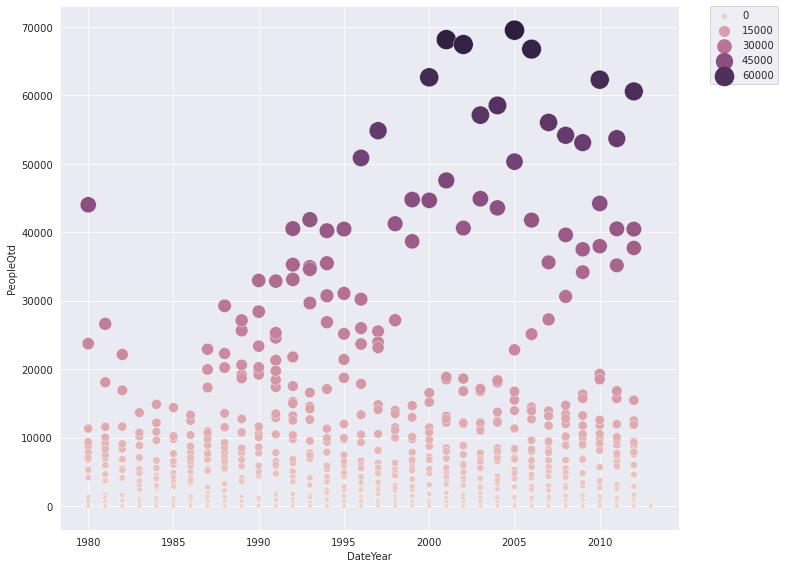

In [127]:
sns.set_style("darkgrid")
f, axes = plt.subplots(1,1, figsize=(11,8))

i01 = sns.scatterplot(data=df_canada_migration_flow, x="DateYear",y="PeopleQtd", hue="PeopleQtd",\
                 size="PeopleQtd", sizes=(20, 400))#, ax=axes[0,1])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()

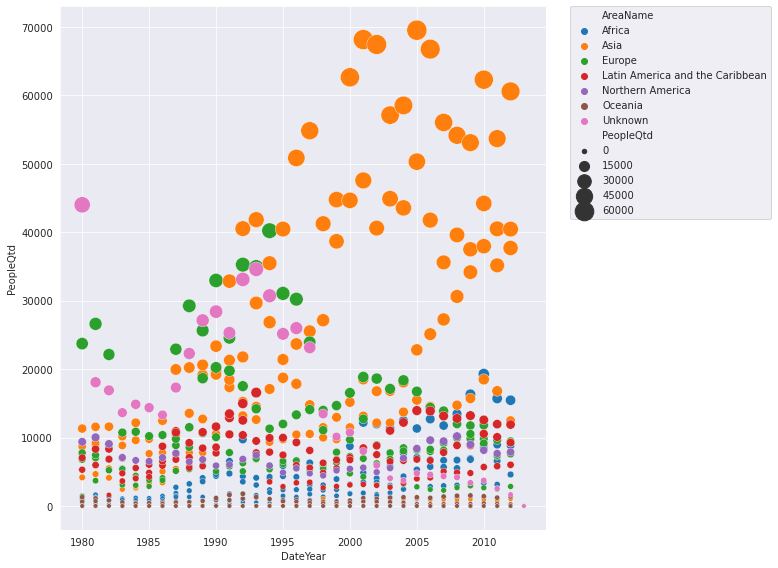

In [111]:
sns.set_style("darkgrid")
f, axes = plt.subplots(1,1, figsize=(11,8))

sca = sns.scatterplot(data=df_canada_migration_flow, x="DateYear", y="PeopleQtd", hue="AreaName", \
                 size="PeopleQtd", sizes=(20, 400))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()

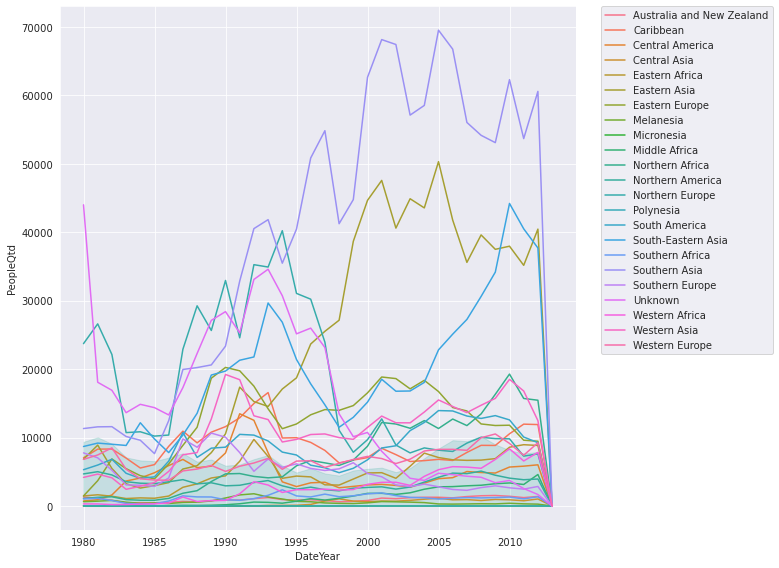

In [107]:
sns.set_style("darkgrid")
f, axes = plt.subplots(1,1, figsize=(11,8))

XRegName = sns.lineplot(data=df_canada_migration_flow, x="DateYear", y="PeopleQtd", hue="RegName", \
                   markers=True, dashes=False)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()

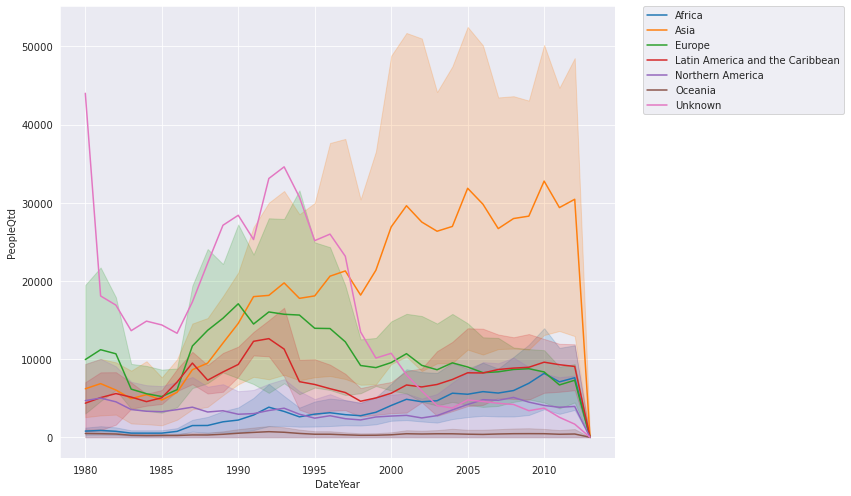

In [119]:
sns.set_style("darkgrid")
f, axes = plt.subplots(1,1, figsize=(12,7))

XAreaName = sns.lineplot(data=df_canada_migration_flow, x="DateYear", y="PeopleQtd", hue="AreaName", \
                   markers=True, dashes=False)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()

In [82]:
#df_canada_citizen_sort = df_canada_migration_citizen.sort_values('PeopleQtd',ascending = False).groupby('OdName').head(2)

#sns.scatterplot(data=df_canada_citizen_sort, x="DateYear",y="PeopleQtd", hue="PeopleQtd",\
#                 size="PeopleQtd")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [203]:
# sns.pairplot(df_canada_migration_flow, hue="RegName")

* Geo Map
* Heatmap 
* Density Plot
* Bubble Plot

In [135]:
#pip install geopandas
#pip install descartes
#pip install mapclassify

In [27]:
import geopandas as gpd

In [89]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]
world_canada = pd.merge(world,
                        df_canada_migration_citizen[df_canada_migration_citizen["DateYear"]==2013], 
                        how="outer", # "left"  "right"
                        left_on=["name"], 
                        right_on=["OdName"])

In [125]:
# world.count() 176
# world_canada["PeopleQtd"].isna().unique()
# world_canada[world_canada["name"]=="Venezuela"]
# world.name.unique()
# df_canada_migration_citizen[df_canada_migration_citizen["RegName"]=="South America"]
#world[world["iso_a3"]=="VEN"]

world_canada[world_canada["RegName"]=="South America"].head(2)


,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Type,Coverage,OdName,AREA,AreaName,REG,RegName,DEV,DevName,DateYear,PeopleQtd
9,44293293.0,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...",Immigrants,Foreigners,Argentina,904,Latin America and the Caribbean,931,South America,902,Developing regions,2013.0,282.0
10,17789267.0,South America,Chile,CHL,436100.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...",Immigrants,Foreigners,Chile,904,Latin America and the Caribbean,931,South America,902,Developing regions,2013.0,273.0


<AxesSubplot:>

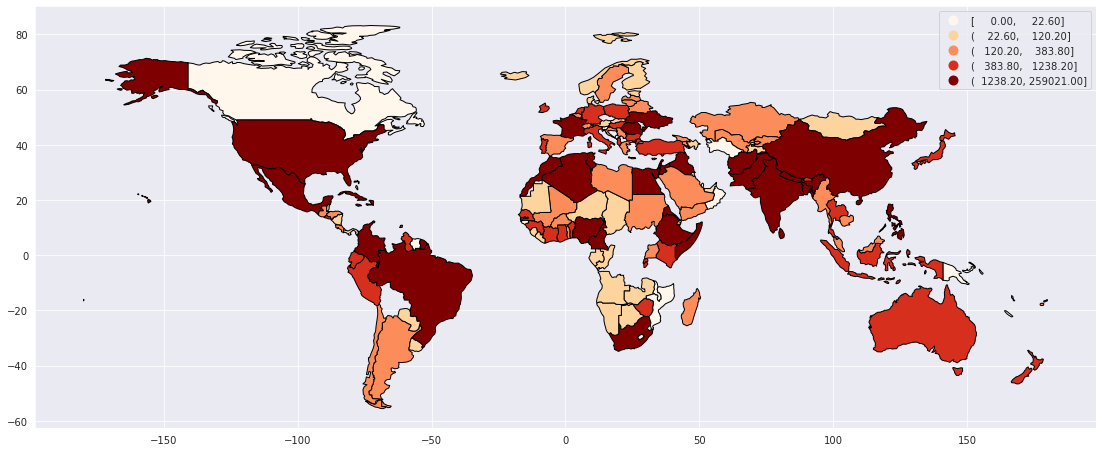

In [117]:
#from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1, figsize=(19,10))

#divider = make_axes_locatable(ax)

#cax = divider.append_axes("right", size="5%", pad=0.1)

world_canada.plot(column='PeopleQtd',
                  ax=ax, 
                  edgecolor="black",
                  cmap='OrRd', scheme='quantiles',
                  legend=True, 
#                 cax=cax,
#                  legend_kwds={'label': "Canada International Migration Flows by Country",'orientation': "horizontal"}
                 )

### Heatmap

* Total by Area
* Total by Region

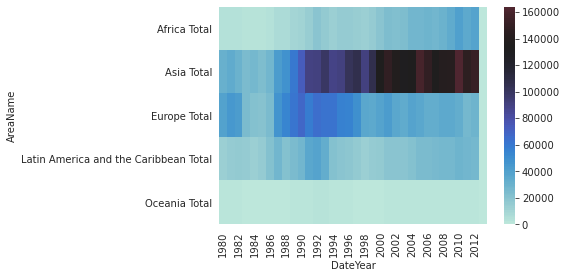

In [285]:
# Total by Area
df_canada_migration_total_heat = df_canada_migration_total.pivot("AreaName","DateYear","PeopleQtd")
ax = sns.heatmap(df_canada_migration_total_heat,center=df_canada_migration_total_heat.loc["Asia Total", 2000])

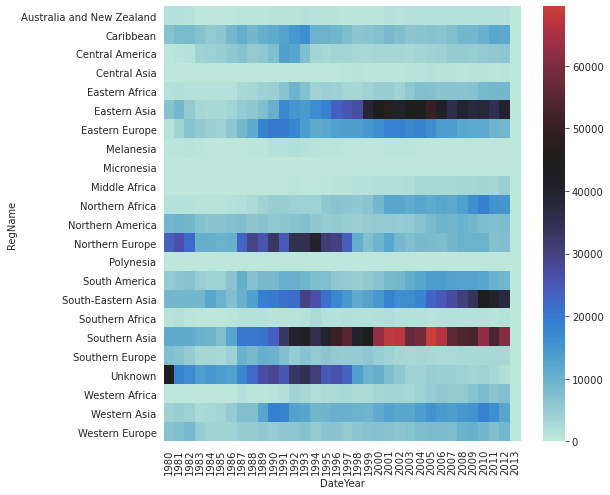

In [282]:
# Total by Region

ax = plt.subplots(figsize=(8,8))

#df_canada_migration_sort = df_canada_migration_flow.sort_values('PeopleQtd',ascending = False).groupby('RegName').head(2)
df_canada_migration_heat = df_canada_migration_flow[df_canada_migration_flow["Coverage"] == "Foreigners"] \
                                                                        .pivot("RegName","DateYear","PeopleQtd")
ax = sns.heatmap(df_canada_migration_heat,center=df_canada_migration_heat.loc["Eastern Asia", 2000])

In [155]:
print(type(sc),"\n")
print(dir(sc),"\n")
print(sc.version,"\n")
sc.getConf().getAll()

<class 'pyspark.context.SparkContext'> 

['PACKAGE_EXTENSIONS', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_accumulatorServer', '_active_spark_context', '_assert_on_driver', '_batchSize', '_callsite', '_checkpointFile', '_conf', '_dictToJavaMap', '_do_init', '_encryption_enabled', '_ensure_initialized', '_gateway', '_getJavaStorageLevel', '_initialize_context', '_javaAccumulator', '_jsc', '_jvm', '_lock', '_next_accum_id', '_pickled_broadcast_vars', '_python_includes', '_repr_html_', '_serialize_to_jvm', '_temp_dir', '_unbatched_serializer', 'accumulator', 'addFile', 'addPyFile', 'appName', 'applicationId', 'binaryFiles', 'binaryRecords', 'broadca

[('spark.app.name', 'DanApp'),
 ('spark.master', 'spark://172.25.0.101:7077'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.host', 'd22614df6a95'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'app-20201230191525-0002'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '33949')]